In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

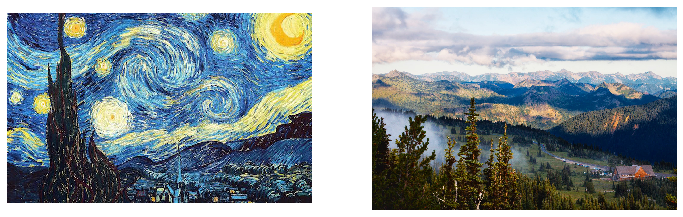

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(load_img('./style.jpg'))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(load_img('./content.jpg'))
plt.axis('off')

plt.show()

In [7]:
from tensorflow.keras.applications import vgg19

In [8]:
def preprocess_img(img_path, img_height=250):
    width, height = load_img(img_path).size
    img_width = int(width * img_height / height)

    img = load_img(img_path, target_size=(img_height, img_width))
    # img.shape = (500, xxxx, 3)
    img = img_to_array(img)

    # img.shape = (1, 500, xxxx, 3)
    img = np.expand_dims(img, axis=0)
    # mean = [103.939, 116.779, 123.68]
    img = vgg19.preprocess_input(img)
    return img

In [9]:
def deprocess_img(img):
    # img.shape == (1, 500, xxx, 3)
    x = img.copy()
    if len(x.shape) == 4:
        # x.shape == (500, xxx, 3)
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
content_layers = [
    'block5_conv2',
]

num_content_layers = len(content_layers)

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

num_style_layers = len(style_layers)

In [11]:
from tensorflow.python.keras import models

In [12]:
def vgg_layers(layer_names):
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    # frozen the weight
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]

    return models.Model([vgg.input], outputs)

In [13]:
def gram_matrix(input_tensor):
    # input_tensor.shape == (500, 800, 64)
    channels = int(input_tensor.shape[-1]) # 64
    # a.shape == (w*h, channels)
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    # gram.shape == (channels, channels)
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


In [27]:
# One downside to this basic implementation is that it produces a lot of high frequency artifacts
# Decrease these using an explicit regularization term on the high frequency components of the image
# this is often called the total variation loss
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

# this high frequency component is basically an edge-detector
# we also can use sobel edge-detector to get the same result
total_variation_weight = 1e-4
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)


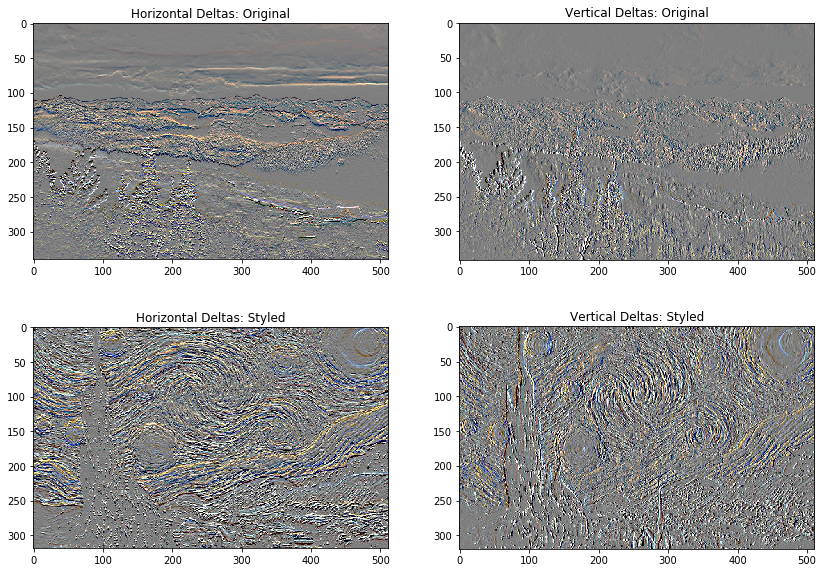

In [15]:
def load_img2(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def imshow2(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

x_deltas, y_deltas = high_pass_x_y(load_img2('./content.jpg'))

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow2(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow2(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(load_img2('./style.jpg'))

plt.subplot(2,2,3)
imshow2(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow2(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")


In [16]:
# then add the total_variation_loss to the previous total_loss
def compute_loss(
        style_targets, content_targets, loss_weights, init_img, outputs):
    style_weight, content_weight = loss_weights

    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    total_loss = style_loss + content_loss
    total_loss += total_variation_weight * total_variation_loss(init_img)
    return total_loss, style_loss, content_loss

In [17]:
def compute_gradients(cfg):
    with tf.GradientTape() as tape:
        outputs = cfg['extractor'](cfg['init_img'])
        all_loss = compute_loss(cfg['style_targets'], cfg['content_targets'], cfg['loss_weights'], cfg['init_img'], outputs)
    total_loss, style_loss, content_loss = all_loss

    return tape.gradient(total_loss, cfg['init_img']), all_loss

In [18]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        for layer in self.vgg.layers:
            layer.trainable = False

    def call(self, image):
        preprocessed_input = image
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [19]:
import time
import IPython
from PIL import Image
import IPython.display

In [28]:
def run_style_transfer(content_path, style_path, n_iterations=300,
                       content_weight=1e4, style_weight=1e-4,
                       display_iterations=True):
    extractor = StyleContentModel(style_layers, content_layers)

    style_targets = extractor(preprocess_img(style_path))['style']
    content_targets = extractor(preprocess_img(content_path))['content']

    init_img = preprocess_img(content_path)
    init_img = tf.Variable(init_img, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'extractor': extractor,
        'loss_weights': loss_weights,
        'init_img': init_img,
        'style_targets': style_targets,
        'content_targets': content_targets
    }


    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(n_iterations):
        print(i)
        start_time = time.time()
        gradients, all_loss = compute_gradients(cfg)
        total_loss, style_loss, content_loss = all_loss
        opt.apply_gradients([(gradients, init_img)])
        clipped = tf.clip_by_value(init_img, min_vals, max_vals)
        init_img.assign(clipped)
        end_time = time.time()

        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_img(init_img.numpy())

        if display_iterations:
            n_rows, n_cols = 2, 5
            display_interval = n_iterations / (n_rows * n_cols)

            if i % display_interval == 0:
                start_time = time.time()

                plot_img = deprocess_img(init_img.numpy())
                imgs.append(plot_img)

                IPython.display.clear_output(wait=True)
                IPython.display.display_png(Image.fromarray(plot_img))


                print('Iteration: %d' % i)
                print(
                    '''Total loss: %.4e,
                      style loss: %.4e,
                      content loss: %.4e, 
                      time: %.4fs''' % (total_loss, style_loss, content_loss,
                                             time.time() - start_time))

    if display_iterations:
        IPython.display.clear_output(wait=True)

        plt.figure(figsize=(14, 4))

        for i, img in enumerate(imgs):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(img)
            plt.axis('off')

        print('Total time: %.4fs' % (time.time() - global_start))

    return best_img, best_loss

Total time: 1470.3376s
6999274.5


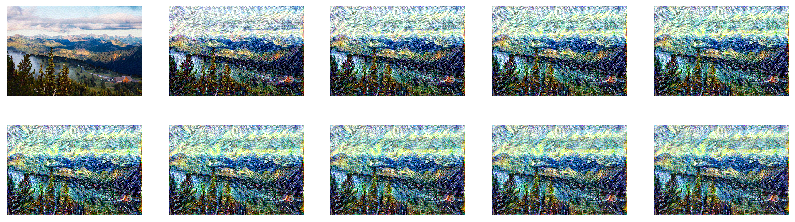

In [29]:
best_img, best_loss = run_style_transfer('./content.jpg', './style.jpg', style_weight=1e-2)
print(best_loss.numpy())

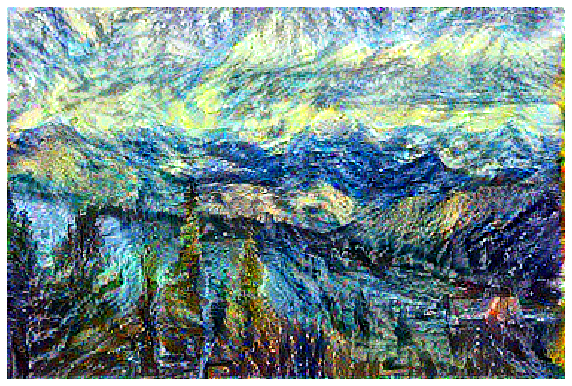

In [30]:
plt.figure(figsize=(10, 10))

plt.imshow(best_img)
plt.axis('off')

plt.show()
